In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"../input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
delta_sp = 0.02
delta_lp = 0.002
delta_sc = 0.02
delta_lc = 0.002

same_day = True
purchase_time = '09:45:00'

max_loss = 7.5

commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

In [2]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
       return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if underlying > strike_sc:
        total_lost = total_lost + (underlying - strike_sc)*100
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if underlying < strike_sp:
        total_lost = total_lost + (strike_sp - underlying)*100
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

def get_amount_lost_minute(contract_date, strike_sp, strike_lp, strike_sc, strike_lc, curr_collected, curr_lost, curr_comm, quote_time, filtered_df):
    if curr_lost > 0.0:
        return pd.Series([curr_lost, curr_comm])
    
    if (quote_time == '16:00:00'):
        return pd.Series([get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc), curr_comm])
    
    df1 = filtered_df[(filtered_df['quote_date']==contract_date) & (filtered_df['expiration']==contract_date)]
    
    df_sp = df1[df1['strike']==strike_sp].min()
    price_sp = (df_sp['ask']+df_sp['bid'])/0.02
    
    df_lp = df1[df1['strike']==strike_lp].min()
    price_lp = (df_lp['ask']+df_lp['bid'])/0.02
    
    df_sc = df1[df1['strike']==strike_sc].min()
    price_sc = (df_sc['ask']+df_sc['bid'])/0.02
    
    df_lc = df1[df1['strike']==strike_lc].min()
    price_lc = (df_lc['ask']+df_lc['bid'])/0.02
    
    curr_cost_to_buy_back = price_sp - price_lp + price_sc - price_lc
    # return curr_value
    if curr_cost_to_buy_back >= (max_loss)*curr_collected:
        return pd.Series([curr_cost_to_buy_back, curr_comm*2])
    
    return pd.Series([0.0, curr_comm])

In [3]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike_sp'] = 0
df_trades['strike_lp'] = 0
df_trades['strike_sc'] = 0
df_trades['strike_lc'] = 0
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0
df_trades['commission'] = 0.0

In [4]:
trade_count = 0

# Create new filtered dataframe with only calls above target delta
if delta_sc > 0.0:
    df_sc = df[(df['type']=="C") & (df['delta']>= delta_sc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    #apply dataframe to get strikes and collect premium
    df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sc), axis = 1).T.values
    trade_count = trade_count + 1

if delta_lc > 0.0:
    df_lc = df[(df['type']=="C") & (df['delta']>= delta_lc) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]
    
    # apply dataframe to get strikes and collect premium
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lc), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_sp > 0.0:
    df_sp = df[(df['type']=="P") & (df['delta']>= delta_sp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_sp), axis = 1).T.values
    trade_count = trade_count + 1

# Create new filtered dataframe with only puts above target delta
if delta_lp > 0.0:
    df_lp = df[(df['type']=="P") & (df['delta']>= delta_lp) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_lp), axis = 1).T.values
    trade_count = trade_count + 1

df_trades['collected'] = df_trades['collected_sc'] + -1*df_trades['collected_lc'] + df_trades['collected_sp'] + -1*df_trades['collected_lp']
df_trades['commission'] = trade_count * commission

In [5]:
for index, trow in df_times.iterrows():
    min_i = int(trow[0][3:5])
    curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
    start_time = time(hour=9, minute=45)
    end_time = time(hour=16)
    if (end_time < curr_time or curr_time <= start_time):
        continue
    filtered_df = df[(df['quote_time']==str(trow[0]))]
    df_trades['lost'], df_trades['commission'] = df_trades.apply(lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc'], row['collected'], row['lost'], row['commission'], str(trow[0]), filtered_df), axis=1).T.values
    
    # print(df_trades.head())
    
    if min_i % 30 == 0:
        print(f"processed {curr_time}")

processed 10:00:00
processed 10:30:00
processed 11:00:00
processed 11:30:00
processed 12:00:00
processed 12:30:00
processed 13:00:00
processed 13:30:00
processed 14:00:00
processed 14:30:00
processed 15:00:00
processed 15:30:00
processed 16:00:00


In [6]:
df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [7]:
df_trades.tail(50)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,strike_sp,strike_lp,strike_sc,strike_lc,delta_sp,delta_lp,delta_sc,delta_lc,net,commission
109,2021-09-13,2021-09-13,25.0,2.5,35.0,5.0,52.5,0.0,4400.0,4320.0,4515.0,4600.0,0.0239,0.0029,0.0311,0.0020,46.5,6.0
110,2021-09-15,2021-09-15,22.5,2.5,35.0,7.5,47.5,0.0,4365.0,4280.0,4490.0,4565.0,0.0235,0.0039,0.0249,0.0020,41.5,6.0
111,2021-09-17,2021-09-17,25.0,2.5,32.5,12.5,42.5,0.0,4390.0,4295.0,4515.0,4585.0,0.0233,0.0057,0.0251,0.0020,36.5,6.0
112,2021-09-20,2021-09-20,30.0,2.5,55.0,25.0,57.5,0.0,4240.0,4190.0,4460.0,4505.0,0.0211,0.0090,0.0209,0.0020,51.5,6.0
113,2021-09-22,2021-09-22,32.5,2.5,45.0,7.5,67.5,0.0,4270.0,4210.0,4440.0,4495.0,0.0233,0.0039,0.0247,0.0020,61.5,6.0
114,2021-09-24,2021-09-24,22.5,2.5,32.5,7.5,45.0,0.0,4370.0,4265.0,4500.0,4570.0,0.0225,0.0035,0.0228,0.0020,39.0,6.0
115,2021-09-27,2021-09-27,20.0,2.5,35.0,10.0,42.5,0.0,4365.0,4280.0,4495.0,4565.0,0.0237,0.0049,0.0209,0.0020,36.5,6.0
116,2021-09-29,2021-09-29,22.5,2.5,42.5,17.5,45.0,0.0,4250.0,4200.0,4420.0,4485.0,0.0211,0.0079,0.0206,0.0020,39.0,6.0
117,2021-09-30,2021-09-30,35.0,2.5,35.0,10.0,57.5,0.0,4280.0,4210.0,4425.0,4495.0,0.0205,0.0049,0.0322,0.0020,51.5,6.0
118,2021-10-01,2021-10-01,35.0,2.5,42.5,10.0,65.0,0.0,4215.0,4165.0,4385.0,4430.0,0.0236,0.0054,0.0244,0.0021,59.0,6.0


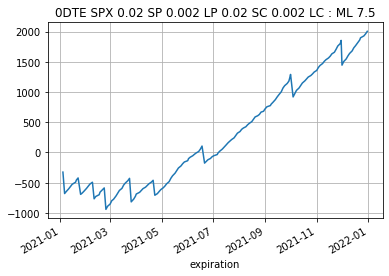

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df_trade_plot.plot(ax=ax)
plt.title(f"0DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"0DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")